<a href="https://colab.research.google.com/github/meryamhzamiensi/Quantum-Enhanced-Deep-Learning-for-Precision-Drug-Design-in-Breast-Cancer-Treatment/blob/ML-models/pcd_classic_decision_tree30d4q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 28.7 MB/s eta 0:00:00


In [ ]:
import os
import psutil
import pandas as pd
import numpy as np
import tracemalloc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import pennylane as qml

In [ ]:
def track_memory_usage():
    """
    Track memory usage of the current process

    Returns:
    dict: Memory usage statistics
    """
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()

    return {
        'rss_mb': memory_info.rss / (1024 * 1024),  # Resident Set Size in MB
        'vms_mb': memory_info.vms / (1024 * 1024),  # Virtual Memory Size in MB
    }

In [ ]:
def calculate_detailed_errors(y_test, y_pred):
    """
    Calculate detailed error metrics

    Parameters:
    y_test (array): True labels
    y_pred (array): Predicted labels

    Returns:
    dict: Error analysis metrics
    """
    # Convert encoded labels back to drug names
    y_test_names = y_test
    y_pred_names = y_pred

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_names, y_pred_names)

    # Detailed error analysis
    error_analysis = {
        'total_samples': len(y_test),
        'misclassified_samples': np.sum(y_test != y_pred),
        'misclassification_rate': 1 - accuracy_score(y_test, y_pred),
        'confusion_matrix': conf_matrix
    }

    # Per-drug error analysis
    drug_error_details = {}
    unique_drugs = np.unique(y_test_names)

    for drug in unique_drugs:
        drug_mask = (y_test_names == drug)
        drug_true = y_test_names[drug_mask]
        drug_pred = y_pred_names[drug_mask]

        drug_error_details[drug] = {
            'total_samples': len(drug_true),
            'correct_predictions': np.sum(drug_true == drug_pred),
            'incorrect_predictions': np.sum(drug_true != drug_pred),
            'accuracy': accuracy_score(drug_true, drug_pred)
        }

    error_analysis['per_drug_details'] = drug_error_details

    return error_analysis

In [ ]:
# Load the dataset
breast_cancer_data = pd.read_csv('processed_dataset.csv')

In [ ]:
    from sklearn.preprocessing import LabelEncoder
    # 7. Prepare target variable (binned LN_IC50)
    y = pd.cut(
        breast_cancer_data['LN_IC50'],
        bins=5,
        labels=['very_low', 'low', 'medium', 'high', 'excellent']
    )
    print("\nTarget class distribution:")
    print(y.value_counts())

    # Encode target labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # 8. Prepare features
    X = breast_cancer_data.drop(columns=['LN_IC50'])

    # 9. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded  # Maintain class distribution
    )

    print(f"\nFinal dataset shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")



Target class distribution:
LN_IC50
medium       6726
high         4457
low          1428
very_low      340
excellent     155
Name: count, dtype: int64

Final dataset shapes:
X_train: (10484, 503), y_train: (10484,)
X_test: (2622, 503), y_test: (2622,)


In [ ]:
breast_cancer_data


,DRUG_ID,LN_IC50,AUC,Z_SCORE,CNA,Gene Expression,Methylation,DRUG_NAME_123829,DRUG_NAME_150412,DRUG_NAME_5-Fluorouracil,...,TARGET_VSP34,"TARGET_WEE1, CHEK1","TARGET_WEE1, PLK1",TARGET_WIP1,"TARGET_XIAP, IAP1, IAP2","TARGET_XIAP, cIAP",TARGET_anti-oxidant proteins,TARGET_dsDNA break induction,"TARGET_mTORC1, mTORC2","TARGET_p38, JNK2"
0,1003,0.317741,0.983262,1.403164,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1003,0.636184,0.969050,1.576546,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1003,1.235544,0.992326,1.902878,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1003,-2.255899,0.861208,0.001898,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1003,-3.247021,0.768404,-0.537737,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13101,2499,11.217375,0.984904,1.411075,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13102,2499,9.653037,0.923493,-0.388438,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13103,2499,10.939549,0.980068,1.091482,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13104,2499,9.100781,0.954554,-1.023718,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# 1. First ensure proper data scaling
scaler = MinMaxScaler(feature_range=(0, np.pi))  # Quantum circuits need angles between 0 and pi
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Set up quantum device (using 10 qubits for this example)
n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)

# Define quantum circuit directly
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # Encode features into quantum states
    for i in range(n_qubits):
        qml.RY(np.pi * inputs[i % len(inputs)], wires=i)

    # Apply entangling layers
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])

    # Apply parameterized rotation gates
    for i in range(n_qubits):
        qml.RX(weights[i], wires=i)

    # Measure all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


In [ ]:
# Initialize quantum weights
quantum_weights = np.random.randn(n_qubits)

In [ ]:
def quantum_transform(X_data):
    # Ensure 2D array input
    if len(X_data.shape) == 1:
        X_data = X_data.reshape(1, -1)

    quantum_features = []
    for sample in X_data:
        # Convert sample to numpy array explicitly
        sample = np.array(sample, dtype=np.float32).flatten()
        quantum_features.append(quantum_circuit(sample, quantum_weights))

    return np.array(quantum_features)

# 4. Apply transformation
try:
    X_train_q = quantum_transform(X_train_scaled)
    X_test_q = quantum_transform(X_test_scaled)
except Exception as e:
    print(f"Error during quantum transformation: {e}")

In [ ]:
# Start memory tracking
tracemalloc.start()

In [ ]:
# Initial memory snapshot
initial_memory = track_memory_usage()
print("Initial Memory Usage:")
print(f"RSS: {initial_memory['rss_mb']:.2f} MB")
print(f"VMS: {initial_memory['vms_mb']:.2f} MB")

Initial Memory Usage:
RSS: 624.10 MB
VMS: 2090.97 MB


In [ ]:
start_time = time.time()

In [ ]:
# Create and train the decision tree classifier
model = DecisionTreeClassifier(max_depth=30, random_state=42)
model.fit(X_train_q, y_train)

DecisionTreeClassifier(max_depth=30, random_state=42)

In [ ]:
end_time = time.time()  # Arrête le chrono
execution_time = end_time - start_time  # Calcul du temps

print(f"Temps d'exécution : {execution_time:.6f} secondes")

Temps d'exécution : 0.291480 secondes


In [ ]:
# Memory usage after training
training_memory = track_memory_usage()
print("\nMemory Usage after Training:")
print(f"RSS: {training_memory['rss_mb']:.2f} MB")
print(f"VMS: {training_memory['vms_mb']:.2f} MB")


Memory Usage after Training:
RSS: 624.10 MB
VMS: 2090.97 MB


In [ ]:
# Get memory allocation details
current, peak = tracemalloc.get_traced_memory()
print(f"\nCurrent memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")
tracemalloc.stop()


Current memory usage: 0.12 MB
Peak memory usage: 0.98 MB


In [ ]:
# Make predictions
y_pred = model.predict(X_test_q)

Accuracy Score: 0.8371472158657514

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.90      0.81        31
           1       0.84      0.85      0.85       892
           2       0.78      0.74      0.76       286
           3       0.86      0.85      0.85      1345
           4       0.67      0.74      0.70        68

    accuracy                           0.84      2622
   macro avg       0.78      0.82      0.79      2622
weighted avg       0.84      0.84      0.84      2622



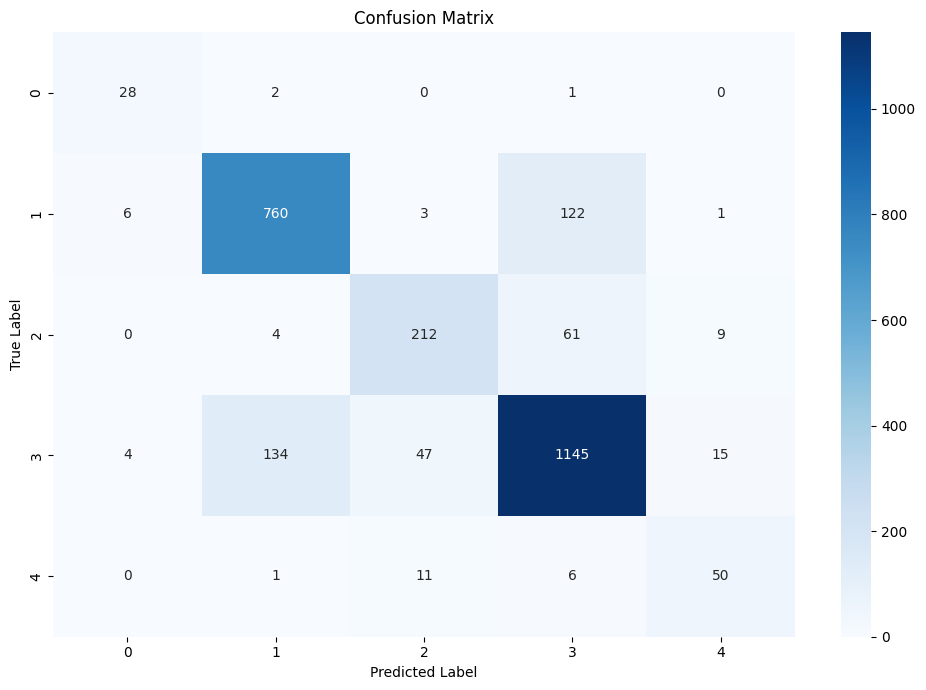

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print model performance
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(10,7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate detailed error metrics
error_analysis = calculate_detailed_errors(y_test, y_pred)

# Print error analysis
print("\nError Analysis:")
print(f"Total Samples: {error_analysis['total_samples']}")
print(f"Misclassified Samples: {error_analysis['misclassified_samples']}")
print(f"Misclassification Rate: {error_analysis['misclassification_rate']:.4f}")


Error Analysis:
Total Samples: 2622
Misclassified Samples: 427
Misclassification Rate: 0.1629


In [ ]:
import pickle

with open('decision_tree_30d_4q_model.pkl', 'wb') as f:
    pickle.dump(model, f)